In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [2]:
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
train_dir = "/Users/sandundesilva/Documents/4th year/machine vision/cw final/backend/dataset/train"
test_dir = "/Users/sandundesilva/Documents/4th year/machine vision/cw final/backend/dataset/test"

In [25]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  class_names = train_data.classes

  # Turn  the images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [26]:
# Image resize
IMG_SIZE = 224

# Create transform pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [27]:
# Set the batch size
BATCH_SIZE = 32 

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x129d41850>,
 ['paper', 'rock', 'scissor'])

torch.Size([3, 224, 224]) tensor(1)


(-0.5, 223.5, 223.5, -0.5)

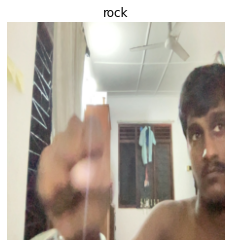

In [28]:
#get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

#get a single image from the batch
image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

1. turn an image into patches
2. flatten the patch feature maps into a single dimension
3. convert the output into desried output (flattened 2D patches): (196,768) ->N*(P2*C) #current shape: (1,768,196)

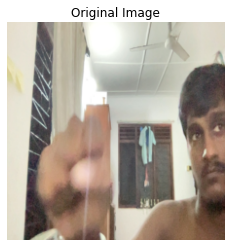

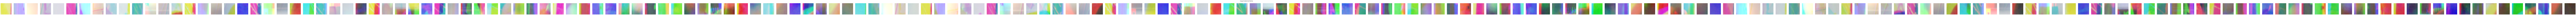

In [29]:
import matplotlib.pyplot as plt
import torch

# Visualize patches
def show_patches(patches, title):
    num_patches = patches.shape[0]
    fig, axes = plt.subplots(1, num_patches, figsize=(3*num_patches, 3))
    for i in range(num_patches):
        axes[i].imshow(patches[i].permute(1, 2, 0))
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()

# Divide image into patches
def divide_into_patches(image, patch_size):
    patches = image.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.contiguous().view(-1, 3, patch_size, patch_size)
    return patches

# Display original image
plt.imshow(image.permute(1, 2, 0))
plt.title("Original Image")
plt.axis(False)
plt.show()

patch_size = 16
patches = divide_into_patches(image, patch_size)

show_patches(patches, "Image Divided into Patches")


torch.Size([3, 224, 224]) tensor(1)


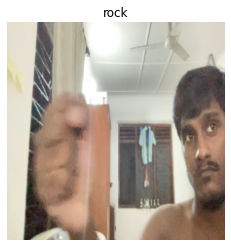

In [30]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [31]:
# Create a class which subclasses nn.Module
# Turn a 2D image into a 1D sequence learnable embedding vector.
class PatchEmbedding(nn.Module):

    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # Layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # Layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
   
        return x_flattened.permute(0, 2, 1) 

In [32]:
# Test on single image
patch_size =16

def set_seeds(seed: int=42):

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    
    
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [33]:
# View the patch embedding and patch embedding shape

print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.9195,  0.2485, -0.2526,  ...,  0.6854, -0.4141,  0.3229],
         [-0.7965,  0.1913, -0.2686,  ...,  0.6685, -0.4086,  0.2715],
         [-0.6083,  0.1669, -0.0795,  ...,  0.4342, -0.2339,  0.0212],
         ...,
         [-0.5033,  0.0633, -0.1258,  ...,  0.3331, -0.2378,  0.1822],
         [-0.4341,  0.0442, -0.1253,  ...,  0.2509, -0.1936,  0.1794],
         [-0.3894,  0.0334, -0.1053,  ...,  0.2350, -0.1697,  0.1642]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [34]:
# Add the the learnable class embedding and position embeddings
# From start to positional encoding: All in 1 cell

set_seeds()

# Set patch size
patch_size = 16

# Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")



# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) 
print(f"Class token embedding shape: {class_token.shape}")

# Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) 


# Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

print(patch_embedding_class_token)


Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9195,  0.2485, -0.2526,  ...,  0.6854, -0.4141,  0.3229],
         [-0.7965,  0.1913, -0.2686,  ...,  0.6685, -0.4086,  0.2715],
         ...,
         [-0.5033,  0.0633, -0.1258,  ...,  0.3331, -0.2378,  0.1822],
         [-0.4341,  0.0442, -0.1253,  ...,  0.2509, -0.1936,  0.1794],
         [-0.3894,  0.0334, -0.1053,  ...,  0.2350, -0.1697,  0.1642]]],
       grad_fn=<CatBackward0>)


In [35]:
# Create a class that inherits from nn.Module
# Creates a multi-head self-attention block ("MSA block" for short).
class MultiheadSelfAttentionBlock(nn.Module):

    # Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False)
        return attn_output

In [36]:
# Create a class that inherits from nn.Module
# Creates a layer normalized multilayer perceptron block ("MLP block" for short).
class MLPBlock(nn.Module):
    # Initialize the class with hyperparameters
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout) # Dropout applied after every dense layer
        )
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [37]:
# Create a class that inherits from nn.Module
# Creates a Transformer Encoder block.
class TransformerEncoderBlock(nn.Module):
    # Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # Create a forward() method  
    def forward(self, x):
        
        # Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        x = self.mlp_block(x) + x 
        
        return x
    


In [38]:


transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [39]:
# Create a ViT class that inherits from nn.Module
# Creates a Vision Transformer architecture with ViT-Base hyperparameters by default.
class ViT(nn.Module):
    # Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0, 
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): 
        super().__init__()
        
        # Make the image size is divisible by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # Calculate number of patches
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # Create learnable class embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    def forward(self, x):
        
        # Get batch size
        batch_size = x.shape[0]
        
        # Create class token embedding and expand it to match the batch size
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension

        # Create patch embedding
        x = self.patch_embedding(x)

        # Concat class embedding and patch embedding
        x = torch.cat((class_token, x), dim=1)

        # Add position embedding to patch embedding
        x = self.position_embedding + x

        # Run embedding dropout
        x = self.embedding_dropout(x)

        # Pass patch, position and class embedding through transformer encoder layers
        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0])

        return x       

In [40]:
# Create an instance of ViT with the number of classes we're working with (rock, paper, scissor)
vit = ViT(num_classes=len(class_names))


In [44]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3,
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper
                             weight_decay=0.3)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Python(30138) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30139) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30140) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30141) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30142) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30143) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30144) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30145) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 1 | train_loss: 1.9833 | train_acc: 0.3306 | test_loss: 1.2355 | test_acc: 0.3125


Python(30167) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30168) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30169) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30170) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30171) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30172) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30173) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30174) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30572) Malloc

Epoch: 2 | train_loss: 1.1420 | train_acc: 0.3224 | test_loss: 1.1342 | test_acc: 0.3125


Python(30621) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30622) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30623) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30624) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30625) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30628) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30827) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30828) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30829) Malloc

Epoch: 3 | train_loss: 1.1230 | train_acc: 0.3166 | test_loss: 1.1137 | test_acc: 0.3125


Python(30847) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30848) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30849) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30850) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30851) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30852) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30853) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(30854) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31224) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31225) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31226) Malloc

Epoch: 4 | train_loss: 1.1455 | train_acc: 0.3199 | test_loss: 1.1460 | test_acc: 0.3125


Python(31249) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31250) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31251) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31252) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31254) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31255) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31256) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31610) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31611) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31612) Malloc

Epoch: 5 | train_loss: 1.1111 | train_acc: 0.3248 | test_loss: 1.1024 | test_acc: 0.3750


Python(31625) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31628) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31629) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31630) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31631) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31632) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31918) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31919) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31920) Malloc

Epoch: 6 | train_loss: 1.1186 | train_acc: 0.3306 | test_loss: 1.0968 | test_acc: 0.3750


Python(31932) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31933) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31934) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31935) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31936) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31937) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31938) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(31939) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32263) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32264) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32265) Malloc

Epoch: 7 | train_loss: 1.1135 | train_acc: 0.3355 | test_loss: 1.0984 | test_acc: 0.3750


Python(32279) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32280) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32281) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32282) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32283) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32284) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32285) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32286) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32629) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32630) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32631) Malloc

Epoch: 8 | train_loss: 1.1056 | train_acc: 0.3183 | test_loss: 1.0986 | test_acc: 0.3750


Python(32645) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32646) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32647) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32648) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32649) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32650) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32651) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32652) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32996) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32997) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32998) Malloc

Epoch: 9 | train_loss: 1.1014 | train_acc: 0.3528 | test_loss: 1.1264 | test_acc: 0.3125


Python(33047) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(33048) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(33049) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(33050) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(33051) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(33052) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(33053) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(33054) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(33278) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(33279) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(33280) Malloc

Epoch: 10 | train_loss: 1.1042 | train_acc: 0.3363 | test_loss: 1.0963 | test_acc: 0.3750


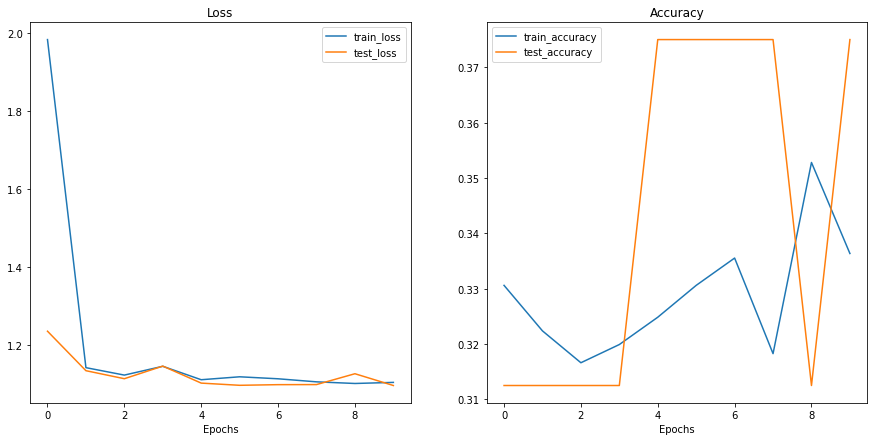

In [45]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

In [46]:
import torch

vit_model = ViT()

model_path = "scratch_vit_model.pth"

torch.save(vit_model.state_dict(), model_path)
